In [1]:
!pip3 install gmpy2
!pip3 install tensorflow

     |████████████████████████████████| 3.6 MB 4.3 MB/s 
     |████████████████████████████████| 462 kB 3.9 MB/s 


In [2]:
%matplotlib inline

import ctypes
import gmpy2
from gmpy2 import mpz
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import keras
import tensorflow as tf
from tensorflow.keras import layers
from keras import backend as K
from keras.models import Model
from keras.engine.input_layer import Input
from keras.layers.core import Activation, Dense
from keras.layers import Flatten, Reshape,LSTM,Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.merge import concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.models import load_model

In [3]:
m_bits = 16
k_bits = 16
c_bits = 16
pad = 'same'

m_train = (m_bits+ k_bits)

In [4]:
K.clear_session()

##### Alice network #####
#
ainput0 = Input(shape=(m_bits,)) #message
ainput1 = Input(shape=(k_bits,)) #key
ainput = concatenate([ainput0, ainput1], axis=1)


x = keras.Sequential(
    [
        layers.Dense(units=(m_bits + k_bits),activation="tanh"),
        layers.Reshape((m_bits + k_bits, 1,)),
        layers.LSTM(units=32,return_sequences=True),
        layers.LSTM(units=256,return_sequences=True),
        layers.LSTM(units=1024),
        layers.Dense(4096,activation="relu"),
        layers.Dropout(0.1),
        layers.Dense(16,activation="relu"),
    ]
)
x.compile(loss='mse', optimizer='sgd')
alice_output=x(ainput)
alice=Model(ainput, alice_output, name='alice')
# print(alice_output.shape)

##### Bob network #####
#
binput0 = Input(shape=(c_bits,)) #ciphertext
binput1 = Input(shape=(k_bits,)) #key
binput = concatenate([binput0, binput1], axis=1)

y = keras.Sequential(
    [
        layers.Dense(units=(m_bits + k_bits),activation="tanh"),
        layers.Reshape((m_bits + k_bits, 1,)),
        layers.LSTM(units=32,return_sequences=True),
        layers.LSTM(units=256,return_sequences=True),
        layers.LSTM(units=1024),
        layers.Dense(4096,activation="relu"),
        layers.Dropout(0.1),
        layers.Dense(16,activation="relu"),
    ]
)
y.compile(loss='mse', optimizer='sgd')
binp= concatenate([alice_output,binput1],axis=1)
bob_output=y(binp)
# print(binp.shape)
# print(y.summary)
# print(bob_output.shape)
bob = Model(binp, bob_output, name='bob')

#bob.summary()

# Eve network
#
einput = Input(shape=(c_bits,)) #ciphertext only
z = keras.Sequential(
    [
        layers.Dense(units=(c_bits + k_bits),activation="tanh"),
        layers.Reshape((c_bits + k_bits, 1,)),
        layers.LSTM(units=32,return_sequences=True),
        layers.LSTM(units=128,return_sequences=True),
        layers.LSTM(units=1024),
        layers.Dense(1024,activation="relu"),
        layers.Dropout(0.1),
        layers.Dense(16,activation="relu"),
    ]
)
z.compile(loss='mse', optimizer='sgd')
eve_output=z(einput)
eve = Model(einput, eve_output, name='eve')
#eve.summary()



In [5]:
aliceout =alice(concatenate([ainput0, ainput1],axis=1))
bobout = bob( concatenate([aliceout,binput1], axis=1))
eveout = eve(aliceout)
#print(eveout.shape)
eveloss = K.mean(  K.sum(K.abs(ainput0 - eveout), axis=-1)  )

bobloss = K.mean(  K.sum(K.abs(ainput0 - bobout), axis=-1)  )
abeloss = bobloss + (K.square(m_bits/2 - eveloss))/( (m_bits//2)**2 )

abeoptim = RMSprop(lr=0.001)
eveoptim = RMSprop(lr=0.001) 


abemodel = Model([ainput0, ainput1, binput1], bobout, name='abemodel')
abemodel.add_loss(abeloss)
abemodel.compile(optimizer=abeoptim)

x.trainable = False
eve1_model = Model([ainput0, ainput1], eveout, name='evemodel')
eve1_model.add_loss(eveloss)
eve1_model.compile(optimizer=eveoptim)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [6]:
abelosses = []
boblosses = []
evelosses = []

In [7]:
epoch_count = 20
batch_size = 512
n_batches = 128

abecycles = 1
evecycles = 2

print("Training ", epoch_count, "epochs using", n_batches, "batches of size", batch_size)
print("------------------------------------------------")
for epoch in range(1,epoch_count):
    abe_losses = []
    bob_losses = []
    eve1_losses = []
    for iteration in range(n_batches):
        
        # Train the A-B+E network
        #
        x.trainable = True
        for cycle in range(abecycles):
            # Select a random batch of messages, and a random batch of keys
            #
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = abemodel.train_on_batch([m_batch, k_batch,k_batch], None)
            abe_losses.append(loss)
        abelosses.append(loss)
        abeavg = np.mean(abe_losses)

        ainp=concatenate([m_batch, k_batch], axis=1)
        # Evaluate Bob's ability to decrypt a message
        m_enc = x.predict(ainp)
        #print(type(m_enc),type(k_batch))
        binp=concatenate([m_enc,tf.cast(k_batch,tf.float64)],axis=1)  
        m_dec = y.predict(binp)
        loss = np.mean(  np.sum( np.abs(m_batch - m_dec), axis=-1)  )
        bob_losses.append(loss)
        boblosses.append(loss)
        bobavg = np.mean(bob_losses)
        
        # Train the EVE network
        #
        x.trainable = False
        for cycle in range(evecycles):
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = eve1_model.train_on_batch([m_batch, k_batch], None)
            eve1_losses.append(loss)
        evelosses.append(loss)
        eveavg = np.mean(eve1_losses)
       
        #print(len(abelosses),len(evelosses),len(boblosses))
        if iteration % max(1, (n_batches // 100)) == 0:
            print("\rEpoch {:3}: {:3}% | abe: {:2.3f} | eve: {:2.3f} | bob: {:2.3f}".format(epoch, 100 * iteration // n_batches, abeavg, eveavg,bobavg), end="")
            sys.stdout.flush()
    
    print()
    epoch += 1
    
print('Training finished.')

Training  20 epochs using 128 batches of size 512
------------------------------------------------
Epoch   1:  99% | abe: 8.267 | eve: 8.081 | bob: 8.054
Epoch   2:  99% | abe: 8.406 | eve: 8.135 | bob: 8.314
Epoch   3:  99% | abe: 7.999 | eve: 7.996 | bob: 7.999
Epoch   4:  99% | abe: 7.990 | eve: 8.031 | bob: 7.989
Epoch   5:  99% | abe: 8.753 | eve: 8.030 | bob: 8.692
Epoch   6:  99% | abe: 8.001 | eve: 8.021 | bob: 7.996
Epoch   7:  99% | abe: 8.002 | eve: 7.994 | bob: 8.002
Epoch   8:  99% | abe: 7.982 | eve: 8.034 | bob: 7.982
Epoch   9:  99% | abe: 7.994 | eve: 8.011 | bob: 7.994
Epoch  10:  99% | abe: 8.005 | eve: 8.001 | bob: 8.005
Epoch  11:  99% | abe: 7.982 | eve: 8.003 | bob: 7.982
Epoch  12:  99% | abe: 7.995 | eve: 7.992 | bob: 7.995
Epoch  13:  99% | abe: 8.012 | eve: 7.997 | bob: 8.012
Epoch  14:  99% | abe: 8.006 | eve: 8.001 | bob: 8.006
Epoch  15:  99% | abe: 7.999 | eve: 8.004 | bob: 7.999
Epoch  16:  99% | abe: 8.007 | eve: 7.987 | bob: 8.007
Epoch  17:  99% | abe

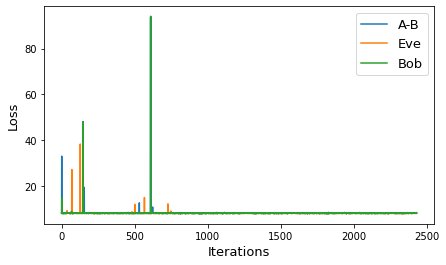

In [8]:
steps = -1

plt.figure(figsize=(7, 4))
plt.plot(abelosses[:steps], label='A-B')
plt.plot(evelosses[:steps], label='Eve')
plt.plot(boblosses[:steps], label='Bob')
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.legend(fontsize=13)

#plt.savefig("images/" + model_name + ".png", transparent=True) #dpi=100
plt.show()

In [9]:
n_examples = 10000

m_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
k_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
ainp=concatenate([m_batch,k_batch], axis=1)
m_enc = x.predict(ainp)
m_dec = (y.predict(concatenate([m_enc, tf.cast(k_batch,tf.float64)],axis=1)) > 0.5).astype(int)
m_att = (z.predict([m_enc,tf.cast(k_batch,tf.float64)]) > 0.5).astype(int)

bdiff = np.abs(m_batch - m_dec)
bsum = np.sum(bdiff, axis=-1)
ediff = np.abs(m_batch - m_att)
esum = np.sum(ediff, axis=-1)


print("Bob % correct: ", 100.0*np.sum(bsum == 0) / n_examples, '%')
print("Eve % correct: ", 100.0*np.sum(esum == 0) / n_examples, '%')



Bob % correct:  0.0 %
Eve % correct:  0.0 %


In [ ]:
x.trainable = False

abelosses = []
boblosses = []
evelosses = []
eve2losses=[]

In [ ]:
epoch_count = 20
batch_size = 512
n_batches = 128

abecycles = 1
evecycles = 2

print("Training ", epoch_count, "epochs using", n_batches, "batches of size", batch_size)
print("------------------------------------------------")
for epoch in range(1,epoch_count):
    abe_losses = []
    bob_losses = []
    eve1_losses = []
    for iteration in range(n_batches):
        
        # Train the A-B+E network
        #
        x.trainable = True
        for cycle in range(abecycles):
            # Select a random batch of messages, and a random batch of keys
            #
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = abemodel.train_on_batch([m_batch, k_batch,k_batch], None)
            abe_losses.append(loss)
        abelosses.append(loss)
        abeavg = np.mean(abe_losses)

        ainp=concatenate([m_batch, k_batch], axis=1)
        # Evaluate Bob's ability to decrypt a message
        m_enc = x.predict(ainp)
        #print(type(m_enc),type(k_batch))
        binp=concatenate([m_enc,tf.cast(k_batch,tf.float64)],axis=1)  
        m_dec = y.predict(binp)
        loss = np.mean(  np.sum( np.abs(m_batch - m_dec), axis=-1)  )
        bob_losses.append(loss)
        boblosses.append(loss)
        bobavg = np.mean(bob_losses)
        
        # Train the EVE network
        #
        x.trainable = False
        for cycle in range(evecycles):
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = eve1_model.train_on_batch([m_batch, k_batch], None)
            eve1_losses.append(loss)
        evelosses.append(loss)
        eveavg = np.mean(eve1_losses)
        # Train the EVE2 network
        #
        
        if iteration % max(1, (n_batches // 100)) == 0:
            print("\rEpoch {:3}: {:3}% | abe: {:2.3f} | eve: {:2.3f} | bob: {:2.3f}".format(epoch, 100 * iteration // n_batches, abeavg, eveavg, bobavg), end="")
            sys.stdout.flush()
    
    print()
    epoch += 1
    
print('Training finished.')

Training  20 epochs using 128 batches of size 512
------------------------------------------------
Epoch   1:  99% | abe: 5.797 | eve: 5.958 | bob: 5.723
Epoch   2:  99% | abe: 5.784 | eve: 5.910 | bob: 5.706
Epoch   3:  99% | abe: 5.766 | eve: 5.927 | bob: 5.689
Epoch   4:  99% | abe: 5.729 | eve: 5.971 | bob: 5.654
Epoch   5:  99% | abe: 5.695 | eve: 5.889 | bob: 5.615
Epoch   6:  99% | abe: 5.656 | eve: 5.830 | bob: 5.572
Epoch   7:  99% | abe: 5.641 | eve: 5.866 | bob: 5.562
Epoch   8:  99% | abe: 5.640 | eve: 5.871 | bob: 5.561
Epoch   9:  99% | abe: 5.610 | eve: 5.831 | bob: 5.529
Epoch  10:  99% | abe: 5.604 | eve: 5.820 | bob: 5.522
Epoch  11:  99% | abe: 5.571 | eve: 5.814 | bob: 5.486
Epoch  12:  99% | abe: 5.561 | eve: 5.771 | bob: 5.476
Epoch  13:  99% | abe: 5.580 | eve: 5.719 | bob: 5.493
Epoch  14:  99% | abe: 5.549 | eve: 5.705 | bob: 5.460
Epoch  15:  99% | abe: 5.557 | eve: 5.704 | bob: 5.467
Epoch  16:  99% | abe: 5.553 | eve: 5.749 | bob: 5.468
Epoch  17:  99% | abe

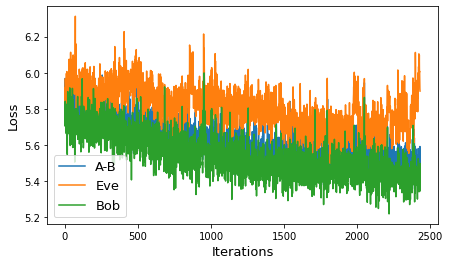

In [ ]:
steps = -1

plt.figure(figsize=(7, 4))
plt.plot(abelosses[:steps], label='A-B')
plt.plot(evelosses[:steps], label='Eve')
plt.plot(boblosses[:steps], label='Bob')
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.legend(fontsize=13)

#plt.savefig("images/" + model_name + "-eve1.png", transparent=True) #dpi=100
plt.show()

In [ ]:
n_examples = 10000

m_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
k_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)

m_enc = alice.predict([m_batch, k_batch])
m_dec = (bob.predict([m_enc, k_batch]) > 0.5).astype(int)
m_att = (eve.predict(m_enc) > 0.5).astype(int)

bdiff = np.abs(m_batch - m_dec)
bsum = np.sum(bdiff, axis=-1)
ediff = np.abs(m_batch - m_att)
esum = np.sum(ediff, axis=-1)

print("Bob % correct: ", 100.0*np.sum(bsum == 0) / n_examples, '%')
print("Eve % correct: ", 100.0*np.sum(esum == 0) / n_examples, '%')

Bob % correct:  0.05 %
Eve % correct:  0.03 %


In [ ]:
import time

while True:
  time.sleep(60)